In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 准备数据

torchvision模块内置了常用的数据集和常见的模型

In [3]:
import torchvision

In [4]:
from torchvision import datasets  # 导入torchvision中的数据集
from torchvision import transforms# 导入转换数据工具的工具集

In [5]:
# transforms.ToTensor()    
#                         ①将任何类型的输入数据转换为一个Tensor,
#                         ②归一化,
#                         ③将数据化图像的channel放在第一维
# transforms.Normalize()   将任何类型的数据标准化到-1~1之间

In [6]:
transformation = transforms.Compose([ # 定义需要对数据集进行的数据转换
    transforms.ToTensor(),
    #transforms.Normalize()
])

In [7]:
# 创建Dataset
train_ds = datasets.MNIST(
                          "data/",                   # 将数据集下载，并存储到指定目录
                          train = True,              # 设定本数据集是否作为训练数据
                          transform = transformation,# 设定数据集需要做何种变换
                          download = True            # 是否将数据及下载到本地
                         )                           # 得到手写数字识别数据集MNIST
test_ds = datasets.MNIST(
                         "data/",
                         train = False,
                         transform = transformation,
                         download = True
                        )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



In [8]:
# 创建DataLoader
train_dl = torch.utils.data.DataLoader(train_ds,batch_size = 64,shuffle = True)
test_dl  = torch.utils.data.DataLoader(test_ds,batch_size = 256,shuffle = False)

In [9]:
# 查看数据
imgs,label = next(iter(train_dl))

In [10]:
imgs.shape                                           # 批量图像的数字形式格式为[图像数量,通道数,高,宽] 也即 [batch,channel,,height,width]  

torch.Size([64, 1, 28, 28])

tensor(2)


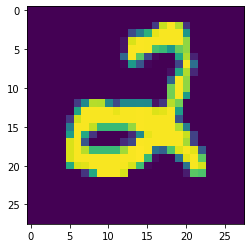

In [11]:
img = imgs[0]                                        # 取出一张图片数据 并进行图形化展示
img = img.numpy()                                    # 将图像从torch转化为numpy
img = np.squeeze(img)                                # 将多余的通道方向上的维度去掉
plt.imshow(img)                                      # 绘制图像
print(label[0])                                      # 输出改图项的正确标签

In [12]:
# 自定义绘图函数
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)

tensor(2)
tensor(6)
tensor(6)
tensor(5)
tensor(3)
tensor(0)
tensor(6)
tensor(9)
tensor(2)
tensor(1)


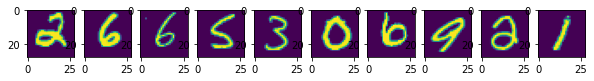

In [13]:
# 测试自定义绘图函数
plt.figure(figsize=(10,1))                            #自定义10张画布
for i,img in enumerate(imgs[:10]):                    #对数据集中的前十张图片
    plt.subplot(1,10,i+1)                             #指定在当前迭代到的位置绘制哪一张图片
    imshow(img)                                       #绘制图片
    print(label[i])                                   #按顺序输出各个图片所对应的标签   

#### 创建模型

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(28*28,1200)
        self.linear_2 = nn.Linear(1200,84)
        self.linear_3 = nn.Linear(84,10)
    
    def forward(self,input):
        x = input.view(-1,28*28)     # 将数据展平为一维数组
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.linear_3(x)
        return x                     # 这里不需要使用sigmoid函数进行二分类

In [15]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    for x,y in trainloader:
        x,y    = x.to(device),y.to(device)
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total # 得到整个样本的平均预测正确率
    
    test_correct      = 0       # 记录正确率
    test_total        = 0       # 记录训练样本总数量
    test_running_loss = 0
    
    with torch.no_grad():
        for x,y in trainloader:
            x,y    = x.to(device),y.to(device)
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [16]:
model               = Model().to(device)
loss_fn             = torch.nn.CrossEntropyLoss()      # 将损失函数定义为交叉熵函数
optim               = torch.optim.Adam(model.parameters(),lr = 0.0001)
epochs              = 20

In [17]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [ ]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.008 	 accuracy:  	 0.871 	 test_loss:  	 0.025 	 test_accuracy:  	 0.925 	
